# Signal Injection for TESS XRP

This notebook goes through how to use software written by Joshua Bromley for the Berkeley SETI Research Center in the Spring of 2021 to inject signals into TESS lightcurves.
This software injects transits from orbital and circumstellar megastructures

In [60]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

## Reading Light Curves

The lightcurves from the TESS satellite are stored in the tess-goddard-lcs bucket. The lightcurves are sorted by sector and then magnitude and each sector has a lookup file and are stored as .pkl files. The lightcurves can either be downloaded directly from the bucket or using unix.
Files can be downloaded from the bucket using the command `gsutil cp gs::/tess-goddard-lcs/path/to/file ./path/to/destination` <br>
If you know the sector and one of the TIC ID, Right Ascension or Declination, the lookupfiles can be searched with `grep "[parameter]" path/to/lookup/file`
You can then take the file path from that to use with gsutil. If you don't know the sector, it can be found in the MAST database. <br>
Details of what data is stored on the .pkl files can be found in the readme in the tess-goddard-lcs bucket

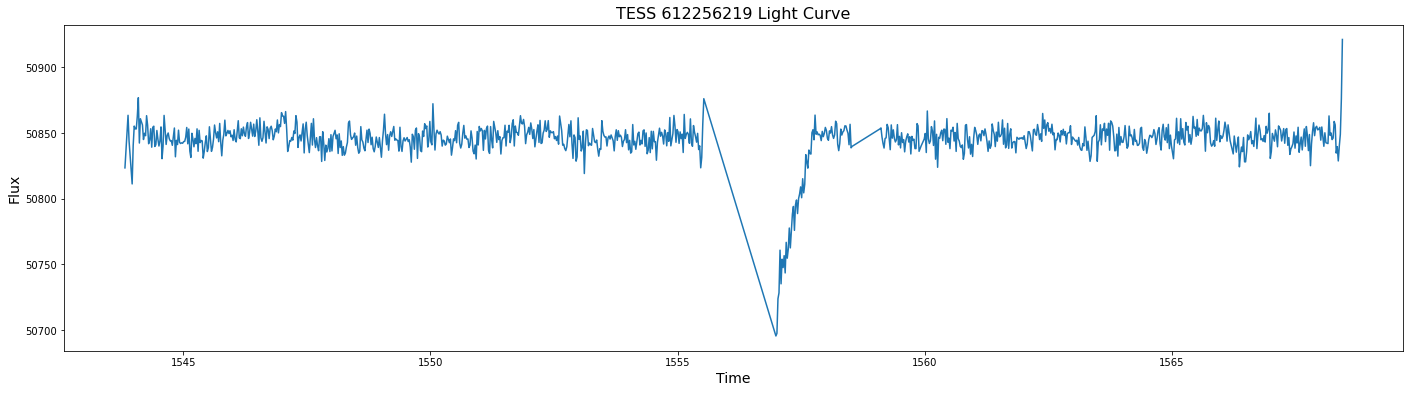

In [61]:
fp = open("./lightcurves/tesslc_364539361.pkl","rb") ##Loading the file
data = pickle.load(fp)
fp.close()

q = data[11]==0 #Extracting the data we want, can only keep high quality data
times = data[6][q]
lc = data[8][q]


fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting for good measure
ax.plot(times,lc)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"TESS 612256219 Light Curve",fontsize=16)
plt.show()

### The time array
The time array from the TESS data is given in modified julian date. Eight Bit Transit centers the transit around 0. Use the TESS time array for the transit, we must shift the time values to include 0. <br>
Additionally, the TESS time array has holes. This is not an issue for a single orbital structure but can become an issue for simulating the transit of an circumstellar structure so we must fill in the gaps.

In [62]:
def fillLightCurve(times, lc):
    ## Fills times gaps with median light curve value
    ##Assumption: Filling gaps with the median flux value will not make the light curve super wierd
    med = np.median(lc)
    dif = []
    for i in range(len(times) -1):
        dif.append(times[i+1]-times[i])
    
    newTimes = []
    newLc = []
    i = 0
    while i < len(times):
        if times[i] - times[i-1] > 1.2*min(dif):
            times = np.insert(times, i, times[i-1]+min(dif))
            lc = np.insert(lc,i,med)
        newTimes.append(times[i])    
        newLc.append(lc[i])
        i += 1
        
    return newTimes, newLc

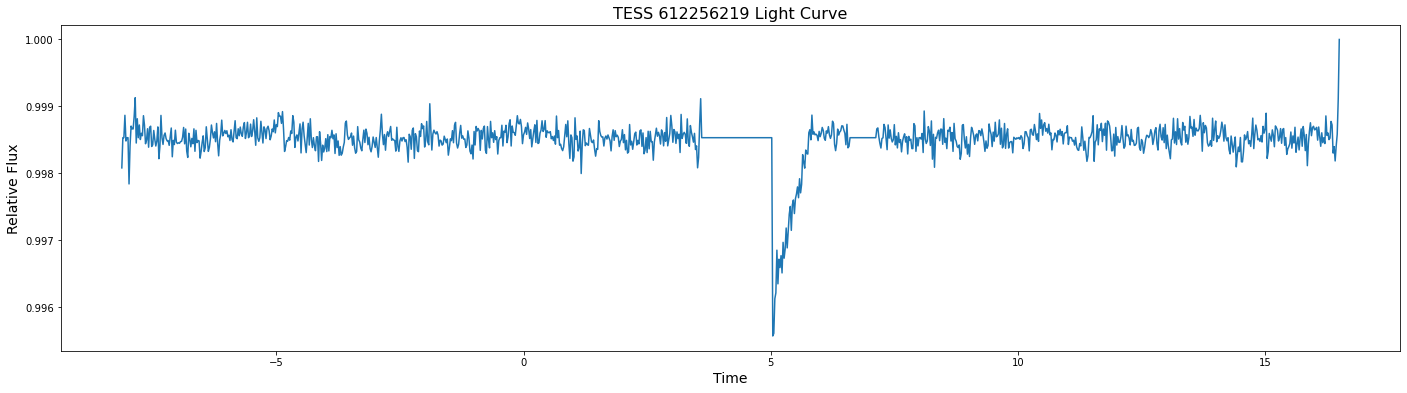

In [63]:
newTimes, newLc = fillLightCurve(times, lc) ##Fill Gaps, run only if generating curves for circumstellar objects
#newTimes = times #Minimizes code changes between orbital and circumstellar structures
#newLc = lc
midTime = np.percentile(newTimes,33) ##Set the 0 point at 1/3. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
##Tess light curves seem to have a 2 day gap near the center
newTimes = newTimes - midTime


maxlc = max(newLc)##Normalize Light Curve
normLc = newLc/maxlc

fig, ax = plt.subplots(1,1,figsize=(24,6))
ax.plot(newTimes,normLc)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative Flux",fontsize=14)
plt.title(r"TESS 612256219 Light Curve",fontsize=16)
plt.show()

## Generating Transits
Transits are generated using the EightBitTransit package, visit their github for more information on the package. This package generates the lightcurve from a user defined shape using a pixel array.


### Orbital Structure
This sections goes over generating the lightcurves of orbital structures. 

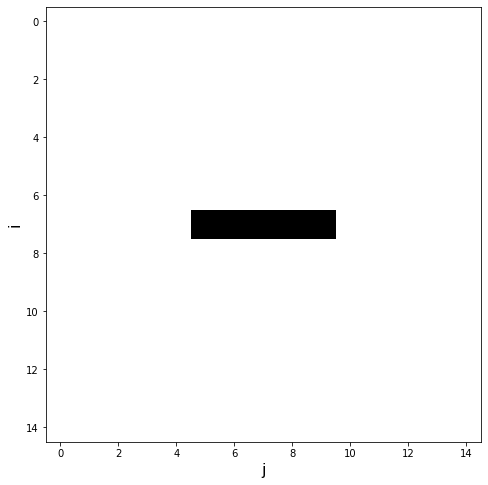

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


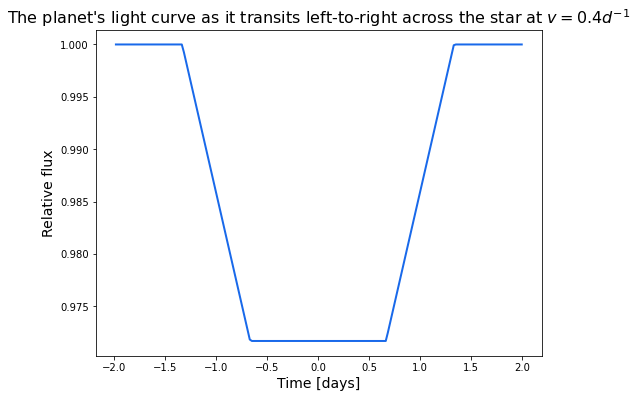

In [53]:
planetGrid = np.zeros((30,30)) 
##Genrate the shape by changing opacity values of this grid [0,1]
##The star being transited has diameter equal to the height of the grid, make your shape accourdingly
planetGrid[14:16,10:20] = 1



planet = TransitingImage(opacitymat = planetGrid, lowres = 15, lowrestype="mean",lowresround = False, v = 1, t_ref = 0, t_arr = newTimes)

planet.plot_grid()

planetLC, overlapTimes = planet.gen_LC(t_arr = newTimes)##Generate Light Curve

fig, ax = plt.subplots(1,1,figsize=(8,6))##Plotting
ax.plot(overlapTimes,planetLC,color="#1969ea",ls="-",lw=2)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The planet's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

### Circumstellar Structure
To generate the lightcurve of a circumstellar structure, we first generate the lightcurve of a section larger than the star transiting. Then we take the section where the object is fully in front of the star and copy it for the entire time lenght. This way we don't have to create on object long enough to transit for 30 days, the lenght of a TESS observation

In [64]:
def cutLightCurve(times, lc, t0, t1): 
    ## Cuts a light curve to be between t0 and t1
    ##Assumption t0 < t1
    newTimes = []
    newLc = []
    i = 0
    while i < len(times):
        if times[i] > t0 and times[i] < t1:
            newTimes.append(times[i])    
            newLc.append(lc[i])
        i += 1
                
    return newTimes,newLc

In [65]:
def duplicateLightCurve(lc,times,t0,t1):
    ##Takes a periodic light curve and extends it while replicating the behavior
    ##Assumptions: The input light curve is some integer multiple of whole periods, the first and last values are the same or similar
    diff = []
    for i in range(len(times) - 1):
        diff.append(times[i+1]-times[i])
        
    i = 1
    while times[0] > t0:
        times = np.insert(times,0,times[0]-min(diff))
        lc = np.insert(lc,0,lc[-i])
        i += 1
    i -= 1
    while times[-1] < t1 + min(diff):
        times = np.insert(times, len(times), times[-1]+min(diff))
        lc = np.insert(lc,len(lc),lc[i])
        i += 1
    return lc, times

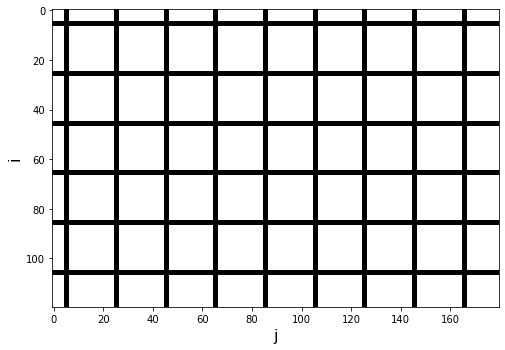

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


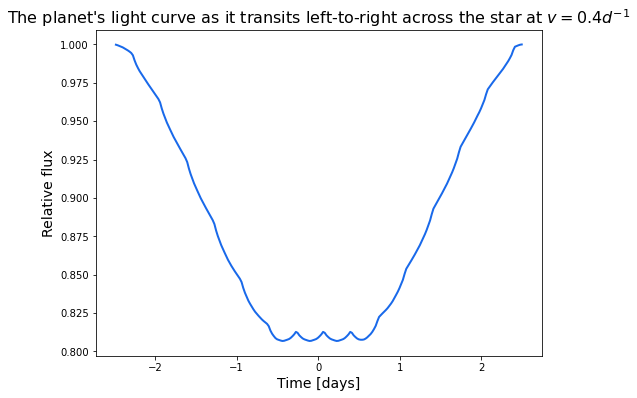

In [66]:
planetGrid = np.zeros((120,180))
##Genrate the shape by changing opacity values of this grid [0,1]
##The star being transited has diameter equal to the height of the grid, make your shape 2-3 times as long as the height
planetGrid[5:7,0:180] = 1
planetGrid[25:27,0:180] = 1
planetGrid[45:47,0:180] = 1
planetGrid[65:67,0:180] = 1
planetGrid[85:87,0:180] = 1
planetGrid[105:107,0:180] = 1
planetGrid[0:120,5:7] = 1
planetGrid[0:120,25:27] = 1
planetGrid[0:120,45:47] = 1
planetGrid[0:120,65:67] = 1
planetGrid[0:120,85:87] = 1
planetGrid[0:120,105:107] = 1
planetGrid[0:120,125:127] = 1
planetGrid[0:120,145:147] = 1
planetGrid[0:120,165:167] = 1

planet = TransitingImage(opacitymat = planetGrid, v = 1, t_ref = 0, t_arr = newTimes)

planet.plot_grid()

planetLC, overlapTimes = planet.gen_LC(t_arr = newTimes)##Generate Light Curve


#overlapTimes, planetLC = cutLightCurve(overlapTimes, planetLC, -0.5,0.5)##Cutting the periodic behavior, the bounds of the periodic behavior can be found by plotting the light curve
#planetLC, overlapTimes = duplicateLightCurve(planetLC, overlapTimes, newTimes[0],newTimes[-1] - 1.05*(newTimes[1]-newTimes[0]))##Duplicating the periodic behavior

fig, ax = plt.subplots(1,1,figsize=(8,6))##Plotting
ax.plot(overlapTimes,planetLC,color="#1969ea",ls="-",lw=2)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The planet's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

## Summing the light curves
Now we have to add the signal and the background noise together to create a realistic looking signal

### Orbital Structure
EightBitTransit only gives us part of the light curve where the transit occurs. We must match this to the lenght of the TESS light curves

In [54]:
def extendLC(LC, overlapTimes, times): 
    ##Extends a light curve from Eight Bit Transit by adding full flux to the ends for the desired length
    ##Assumption: Maximum flux value is 1
    ##Assumption: Light curve is at maximum value at the start and end
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    for i in range(len(times)):##Iterate over the desired time array
        if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
            if overlapIndex < len(overlapTimes) - 2:##Only do this to the end of the ebt light curve
                overlapIndex += 1
                extendedLC[i]  = LC[overlapIndex]
        
    
    return extendedLC, times

In [55]:
def sumLightCurves(trueLC, genLC): 
    ##Sums a true light curve and a generated lightcurve
    ##Assumptions: 1 is the maximal value for both light curves
    ##Assumption: The sum of both light curves is greater than one at every point, this can be satisfied by using a non-variable true light curve and leaving >1% as the minimum in the generated curve
    if len(trueLC) - len(genLC) != 0:
        raise Exception("Light Curves must be the same size: " + str(len(trueLC))+ "," + str(len(genLC)))
    sumLC = trueLC + genLC - 1
    ##Generated Light curve has no noise, subtracting 1 from this light curve gives reduction due to transit
    ##Preserves noise in original light curve (average would half it)
    ##Assumes min value in both light curves >0.5, anything violating this assumption is grounds for further investigation in itself 
    return sumLC

Filename: longRectangle


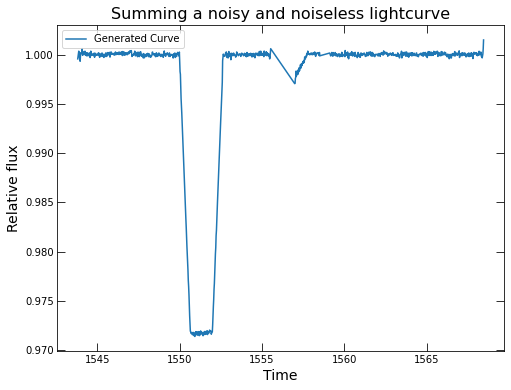

In [56]:
longTransitLC, overlapTimes = extendLC(planetLC, overlapTimes, newTimes)##Extending the light curve to match the TESS curve
sumLC = sumLightCurves(normLc, longTransitLC)##Summing and normalizing lightcurves
medLC = np.median(sumLC)
sumLC = sumLC/medLC
overlapTimes = overlapTimes + midTime ##Resetting time array to original values

fig, ax = plt.subplots(1,1,figsize=(8,6))##PLotting
ax.plot(overlapTimes,sumLC,label = "Generated Curve", ls = '-')
ax.legend()
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"Summing a noisy and noiseless lightcurve",fontsize=16)

ax.tick_params(direction = "in", which = "major", length = 8, top = True, right = True)
ax.tick_params(direction = "in", which = "minor", length = 4, top = True, right = True)

filename = input("Filename:") ##Prompt to not forget to change the file name and overwrite existing outputs

plt.savefig("./output/"+filename)
plt.show()

### Circumstellar Structure
We don't have to adjust the size of the light curve becuase we made it the right size when duplicating the periodic behavior. We do have to put the time holes back in so that the neural net doesn't think the lack of time holes is anomalous

In [43]:
def cleanTimes(lc, times, newTimes):
    ##Removes all datapoints from lc and times when an element in the times array does not have a corresponding element in the newTimes array
    ##Removes the filling done by cutTimes, use these two functions in conjunction
    ##Assumption: times array is larger than newTimes
    ##Assumption: times[0] = newTimes[0]
    ##Assumption: The difference between the first two elements in the times array is representative of a typical difference
    i = 0
    diff = times[1] - times[0]
    while i < len(newTimes) and i < len(times):
        if abs(newTimes[i] - times[i]) > 0.9*diff:
            times = np.delete(times, i)
            lc = np.delete(lc,i)
        else:
            i += 1
    return lc, newTimes

Filename: grid


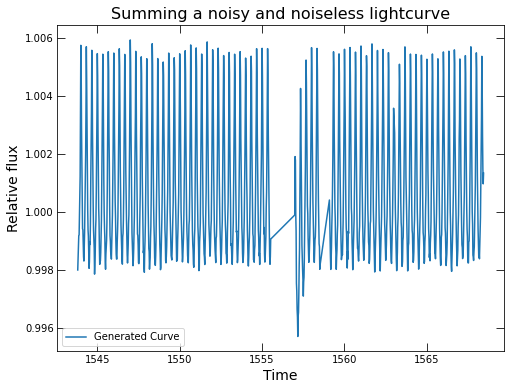

In [49]:
sumLC = sumLightCurves(normLc, planetLC)##Summing and normalizing lightcurves
medLC = np.median(sumLC)
sumLC = sumLC/medLC
overlapTimes = overlapTimes + midTime

sumLC, overlapTimes = cleanTimes(sumLC, overlapTimes, times)##Removing the filled in holes


fig, ax = plt.subplots(1,1,figsize=(8,6))##PLotting
ax.plot(overlapTimes,sumLC,label = "Generated Curve", ls = '-')
ax.legend()
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"Summing a noisy and noiseless lightcurve",fontsize=16)

ax.tick_params(direction = "in", which = "major", length = 8, top = True, right = True)
ax.tick_params(direction = "in", which = "minor", length = 4, top = True, right = True)

filename = input("Filename:") ##Prompt to not forget to change the file name and overwrite existing outputs

plt.savefig("./output/"+filename)
plt.show()